### Algorithm for the analysis of the Medibio's ECG file set. 

###### written by Nicola Pastorello 19/0/2015

In [2]:
%matplotlib inline
# Loading libraries
import numpy as np
import pandas as pd
import datetime, pickle
import os, glob, sys
from pylab import *
from scipy import signal, misc



In [189]:
# Functions
def findCharPos(stringInput, c=' '):
    for ii in np.arange(len(stringInput)):
        if stringInput[ii] == c:
            return ii, stringInput[:ii]
    return False

def rollingMean(values, binSize=1):
    listMean = []
    for ii in np.arange(len(values)-binSize+1):
        listMean.append(np.mean(values[ii:ii+binSize]))
    return np.array(listMean)
    
def rollingStd(values, binSize=1):
    listStd = []
    for ii in np.arange(len(values)-binSize+1):
        listStd.append(np.std(values[ii:ii+binSize]))
    return np.array(listStd)
    
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2
    return (fair_area - area) / fair_area

# def Gini(array):
#     nn = len(array)
#     array_sort = sort(array)
#     frac_num, frac_den = 0., 0.
#     for ii in np.arange(nn):
#         frac_num += (nn+1-ii)*array_sort[ii]
#         frac_den += array_sort[ii]
#     return (nn+1-2.*frac_num/frac_den)/nn

def rollingGini(values, binSize=1):
    listStd = []
    for ii in np.arange(len(values)-binSize+1):
        listStd.append(gini(values[ii:ii+binSize]))
    return np.array(listStd)

def cumulativeGini(values, reverse=False):
    listGini = []
    if reverse:
        cumArray = values.copy()
        values = dfTmp['hb'][selSleep[0]]
        for ii in np.arange(len(values)):
            if ii == 0:
                tmpArray = cumArray
            else:
                tmpArray = cumArray[:-ii]
                
            listGini.append(gini(tmpArray))        
    else:
        cumArray = []
        for ii in values:
            cumArray.append(ii)
            listGini.append(gini(cumArray))
    return np.array(listGini)




def rollingGaussian(values, binSize=1):
    w = signal.gaussian(len(values), binSize)
    #
    convolvedProf = np.convolve(values, w, mode='same')
    #
    normConvProf = convolvedProf/np.median(convolvedProf)
    normProf = values/np.median(values)
    return normProf-normConvProf

0.803408895883
0.364916777446


In [4]:
# Extract input
fileIn = open('dicDF.dat', 'rb')
dicDF = pickle.load(fileIn)
fileIn.close()

# Extracting time in minutes
mm = []
for jj in dicDF[dicDF.keys()[0]]['time']:
    mm.append(jj.hours*60.+jj.minutes)
    
mm = np.array(mm)

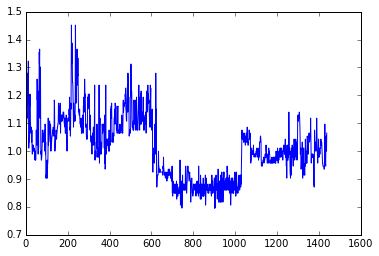

In [155]:
# Example of data
index = np.random.randint(0, len(dicDF))
keyDic = dicDF.keys()[index]
try:
    plot(mm, dicDF[keyDic]['hb']/np.median(dicDF[keyDic]['hb']))
except:
    plot(mm[:-1], dicDF[keyDic]['hb']/np.median(dicDF[keyDic]['hb']))

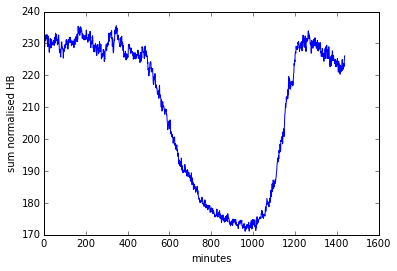

In [6]:
# Summing profiles to extract sleep time window
totProfiles = np.zeros(len(dicDF[dicDF.keys()[0]])-1)
for ii in dicDF.keys():
    if len(dicDF[ii]) != len(totProfiles): 
        totProfiles += dicDF[ii]['hb'][:-1]/np.median(dicDF[ii]['hb'][:-1])
    else:
        totProfiles += dicDF[ii]['hb']/np.median(dicDF[ii]['hb'])

plot(mm[:-1], totProfiles)
xlabel('minutes'); ylabel('sum normalised HB')

selSleep = np.where((mm>600) & (mm<1080))

### For each profile, extract different stats and create dataframe with them. 


STD_gini: 0.0419227173973
STD_Gaussian: 0.101399869643


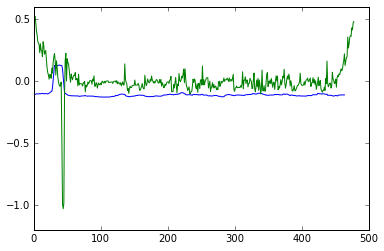

In [7]:
### Comparison between STD_Gini and STD_Gaussian_convolution

dfTmp = dicDF[dicDF.keys()[207]]   # Outliers: 29,  39,  55, 120, 207
binSize = 15
rGini = rollingGini(dfTmp['hb'][selSleep[0]], binSize=binSize)

print 'STD_gini:',std(rGini)
#plot(dfTmp['hb'][selSleep[0]])
plot(rGini, c='b')

rGaussian = rollingGaussian(dfTmp['hb'][selSleep[0]], binSize=binSize)
plot(rGaussian, c='g')
print 'STD_Gaussian:', std(rGaussian[binSize:-binSize]) #Removing wings

#plot(dfTmp['hb'][selSleep[0]])

In [8]:
listGinistd, listConvstd = [], []
listGiniProf, listConvProf = [], []

for ii in dicDF.keys():
    dfTmp = dicDF[ii]    

    # Rolling Gini coefficient -> std
    binSize = 10

    rGini = rollingGini(dfTmp['hb'][selSleep[0]], binSize=binSize)
    #plot(mm[selSleep][:-binSize+1], rGini, c='r')
    #print std(rGini)
    
    listGinistd.append(np.std(rGini))
    listGiniProf.append(rGini)
    
    # Gaussian smoothed signal 
    # I save the standard deviation of the difference between original and
    # smoothed (thus excluding larger scale variations)
    sigmaGaussian = 10. #In minutes
    rGaussian = rollingGaussian(dfTmp['hb'][selSleep[0]], binSize=sigmaGaussian)
    listConvstd.append(std(rGaussian[binSize:-binSize]))
    listConvProf.append(rGaussian[binSize:-binSize])
    
seriesGiniStd = pd.Series(listGinistd)
seriesConvStd = pd.Series(listConvstd)
seriesGiniProf = pd.Series(listGiniProf)
seriesConvProf = pd.Series(listConvProf)
seriesID = pd.Series(dicDF.keys())

dic_coeff = {'ID':seriesID, 'Gini': seriesGiniStd, 'Conv': seriesConvStd}
                             #, 'GiniProf': seriesGiniProf, 'ConvProf': seriesConvProf}
df_coeff = pd.DataFrame(dic_coeff)
             
     


In [9]:
# Finding outliers in relation
selOutliers = np.where(dic_coeff['Gini'] > 0.04)
print selOutliers
print dic_coeff['Gini'][selOutliers[0]]
print dic_coeff['Conv'][selOutliers[0]]

(array([ 29,  39,  55, 120, 207]),)
29     0.096409
39     0.103237
55     0.078504
120    0.058771
207    0.047161
dtype: float64
29     0.205021
39     0.119646
55     0.092257
120    0.151991
207    0.093856
dtype: float64


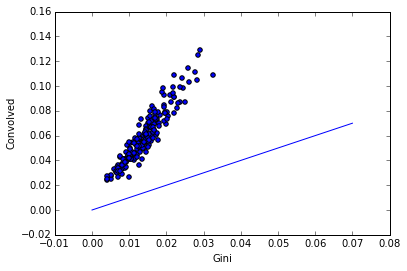

In [10]:
#scatter(dic_coeff['Gini'], dic_coeff['Conv']) #Total
selInliers = np.where(dic_coeff['Gini'] <= 0.04) #Cleaned
scatter(dic_coeff['Gini'][selInliers[0]], dic_coeff['Conv'][selInliers[0]])
plot([0,0.07],[0,.07])
xlabel('Gini'); ylabel('Convolved')

# Removing outliers
df_coeff_clean = df_coeff[df_coeff.Gini <=0.04]

In [11]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Save dataframe as a .csv file with rpy2
# (it works only if each field has a single value (not arrays))

## get a reference to the R function 
write_csv = robjects.r('write.csv')
## save 
write_csv(df_coeff_clean,'dataframe.csv')

# Save dataframe as a Rdata file with rpy2
r_dataframe = pandas2ri.py2ri(df_coeff_clean) 
robjects.globalenv['DF'] = r_dataframe
robjects.r('save(DF, file="dataframe.Rdata")')

# Save dataframe as a pickle object
fileOut = open('dataframe.dat', 'wb')
pickle.dump(df_coeff_clean, fileOut)
fileOut.close()


# Save series of rolling Gini profiles as .csv
write_csv = robjects.r('write.csv')
write_csv(seriesConvProf,'rGiniprof.csv')

# Save series of rolling Gini profile as R matrix
robjects.globalenv['GiniProfMatrix'] = np.array(matrix(listGiniProf))
robjects.r('save(GiniProfMatrix, file="matrix.Rdata")')

rpy2.rinterface.NULL

###### Experimental stuff

###### Extracting cumulative Gini profiles histograms to characterise trends in the general trends

Fileset0_csv/HL118025.csv 272.347720148
Fileset0_csv/HL159044.csv 973.383744199
Fileset0_csv/HL477022.csv -657.552902843


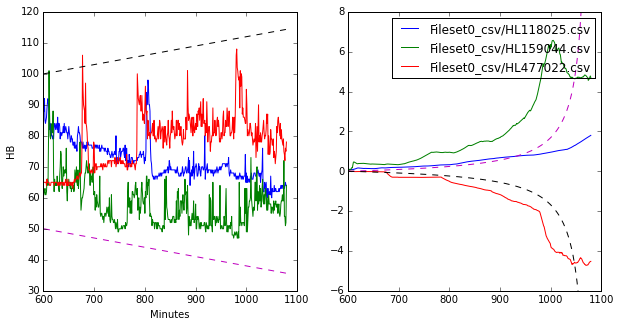

In [190]:
fig = figure(figsize=(10,5))
ax1, ax2 = subplot(121), subplot(122)


for ii in dicDF.keys()[0:3]:
    dfTmp = dicDF[ii]    
    ax1.plot(mm[selSleep[0]],dfTmp['hb'][selSleep[0]])
    medVal = np.median(dfTmp['hb'][selSleep[0]])
    ax2.plot(mm[selSleep[0]],
             cumulativeGini(dfTmp['hb'][selSleep[0]]-medVal
                            #,reverse=True
                           ),
                            label=ii)
    print ii, np.sum(cumulativeGini(dfTmp['hb'][selSleep[0]]-medVal 
                                    #,reverse=True
                                   ))

    
# Reference curves
ax2.set_ylim(ax2.set_ylim())    
legend(loc=1)
y_low = np.arange(len(selSleep[0]))* -0.03+50
ax1.plot(mm[selSleep[0]], y_low, c='m', ls='--')
medVal = np.median(y_low)
ax2.plot(mm[selSleep[0]],
        cumulativeGini(y_low-medVal, 
                       #reverse=True
                      ), c='m', ls='--')

y_high =  np.arange(len(selSleep[0]))* 0.03+100
ax1.plot(mm[selSleep[0]], y_high, c='k', ls='--')
medVal = np.median(y_high)
ax2.plot(mm[selSleep[0]],
        cumulativeGini(y_high-medVal, 
                       #reverse=True
                      ), c='k', ls='--')

# Setting plots
ax1.set_xlabel('Minutes'); ax1.set_ylabel('HB') 
#ax2.set_xlabel('Minutes'); ax2.set_ylabel('Inverse-cumulative normalized Gini coefficient') 



In [198]:
# Measuring integral of all profiles' CnGc profiles

cumGini = pd.Series(name=['ID', 'CnGn'])
for ii in dicDF.keys():
    dfTmp = dicDF[ii]   
    medVal = np.median(dfTmp['hb'][selSleep[0]]) 
    cumGini[ii] = np.sum(cumulativeGini(dfTmp['hb'][selSleep[0]]-medVal 
                                    #,reverse=True
                                   ))



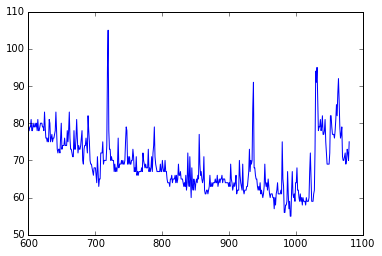

In [220]:
selmax = where(cumGini == max(cumGini.ix[where((~isnan(cumGini)) & (~isinf(cumGini)))]))

dfTmp = dicDF[dicDF.keys()[selmax[0]]]    
plot(mm[selSleep[0]],dfTmp['hb'][selSleep[0]])

# Data with accelerometer values:  170 / 208


' This could be done with MCMC and parallelization '

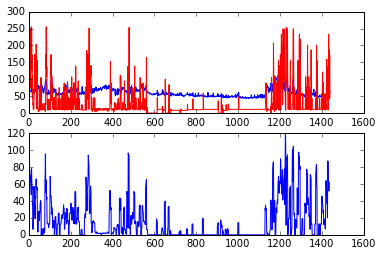

In [85]:
import sets 
# Extract sleeping time from accelerometer
listAcc = []
for ii in dicDF.keys():
#     acc = dicDF[ii]['var1']
#     if not(acc.count(acc[0]) == len(acc)): # Check if all elements are the same
#         listAcc.append(ii)
    if not(len(sets.Set(dicDF[ii]['var1'])) == 1):
        listAcc.append(ii)

print "# Data with accelerometer values: ",len(listAcc),'/', len(dicDF.keys())


fig, axs = plt.subplots(2,1)
aa = dicDF[listAcc[50]]
axs[0].plot(mm, aa['hb'], c='b')
axs[0].plot(mm, aa['var1'], c='r')

# Measuring rolling std
axs[1].plot(rollingStd(aa['var1'], binSize=5))

# To find what is the sleeping time, I'm looking for the 
# largest sequential array (with length between 5 and 10 hours) 
# which sum of rolling std elements is the smallest

''' This could be done with MCMC and parallelization '''

# minSleepTime, maxSleepTime = 5., 10. # In hours
# tmpTableSleep = np.empty((len(mm), (maxSleepTime-minSleepTime)*60.))
# for StartMinute in np.arange(len(mm)):
#     indexx = 0
#     for lengthSleep in np.arange(minSleepTime*60., maxSleepTime*60.):
#         try:
#             tmpTableSleep[StartMinute, indexx] = np.sum(rollingStd(aa['var1'], binSize=5)[StartMinute:StartMinute+lengthSleep])
#         except:
#             tmpTableSleep[StartMinute, indexx] = nan
#         indexx += 1


In [86]:
# Try to fit the sleeping region with a single line. 

import lmfit
from lmfit.models import LinearModel, RectangleModel

dicSlopes = {}
listSlopes = []
for keyDic in dicDF.keys():
    #keyDic = dicDF.keys()[0]    
    dfTmp = dicDF[keyDic]
    
    #plot(mm[selSleep[0]], dfTmp['hb'][selSleep[0]])    
    x, y = mm[selSleep[0]], dfTmp['hb'][selSleep[0]]

    #fig, axs = plt.subplots(2,1)

    linearMod = LinearModel()
    pars = linearMod.guess(y,x=x)
    out = linearMod.fit(y, pars, x=x)
    #axs[0].plot(x, y)
    #axs[0].plot(x, out.init_fit, 'k--')
    #axs[0].plot(x, out.best_fit, 'r-')
    dicSlopes[keyDic] = out.result.params['slope'].value
    listSlopes.append(out.result.params['slope'].value)
# Measuring the standard deviation at different scales
#yy = np.array(dfTmp['hb'][selSleep[0]])


# rectMod = RectangleModel(form = 'linear')
# pars_rect = rectMod.guess(y, x=x)
# out_rect = rectMod.fit(y, pars_rect, x=x)

# axs[1].plot(x, y)
# axs[1].plot(x, out_rect.init_fit, 'k--')
# axs[1].plot(x, out_rect.best_fit, 'r-')

rpy2.rinterface.NULL

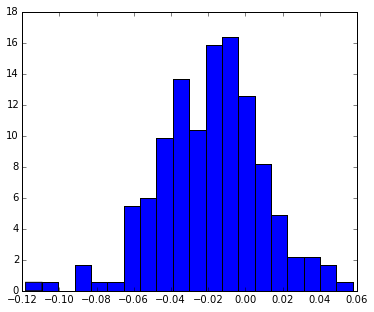

In [87]:
from sklearn import mixture
import matplotlib.pyplot
import matplotlib.mlab

fig = figure(figsize=(6,5)); ax = subplot(111)
clf = mixture.GMM(n_components=4, covariance_type='full')
clf.fit(listSlopes)
m_array = clf.means_
w_array = clf.weights_
c_array = clf.covars_
histdist = ax.hist(listSlopes, 20, normed=True)
for indexG in np.arange(len(m_array)):
    lambda x: ax.plot(x,w_array[indexG]*matplotlib.mlab.normpdf(x,m_array[indexG],np.sqrt(c_array[indexG]))[0], linewidth=3)
# plotgauss2 = lambda x: plot(x,w2*matplotlib.mlab.normpdf(x,m2,np.sqrt(c2))[0], linewidth=3)
# plotgauss1(histdist[1])
# plotgauss2(histdist[1])

DF_slopes = pd.DataFrame.from_dict(dicSlopes, orient='index')

# Save series of slopes as .csv
write_csv = robjects.r('write.csv')
write_csv(DF_slopes,'SleepSlopes.csv')

(-1.4, 1.4)

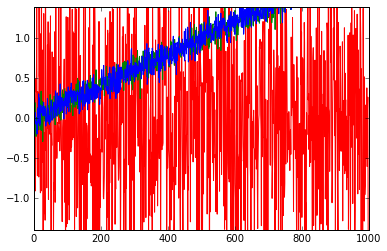

In [123]:
# Check whether rollling Gini is able to discern profiles with different GLOBAL trends

# Create profiles
profileNormal = np.random.randn(1000)
profileUp = +0.02*np.arange(1000)+np.random.randn(1000)
profileDown = -0.02*np.arange(1000)+np.random.randn(1000)

profileUp /= np.median(profileUp)
profileDown /=  np.median(profileDown)
#rollingGini

plot(profileNormal, c='r')
plot(profileDown, c='g')
plot(profileUp, c='b')

ylim(-1.4, 1.4)

(2.1989855648322449, 1.9493361080561791, -1.4812067492152361)

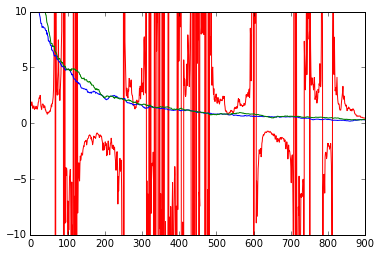

In [168]:
# Creating rolling Gini profiles
rG_normal = rollingGini(profileNormal,binSize=100)
rG_up = rollingGini(profileUp,binSize=100)
rG_down = rollingGini(profileDown,binSize=100)

plot(rG_normal/np.median(rG_normal), c='r')
plot(rG_up/np.median(rG_up), c='b')
plot(rG_down/np.median(rG_down), c='g')
ylim(-10,10)

mean(rG_down/np.median(rG_down)), mean(rG_up/np.median(rG_up)), mean(rG_normal/np.median(rG_normal))

478 3.5


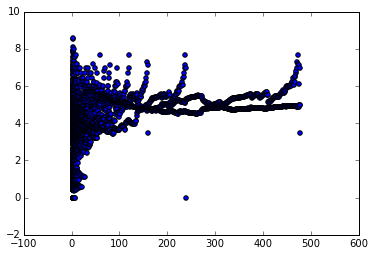

In [65]:
# Try to estimate the Hurst coefficient for a single profile
dfTmp = dicDF[dicDF.keys()[4]]
#plot(mm, dfTmp['hb'])
#plot(mm[selSleep[0]], dfTmp['hb'][selSleep[0]])

# Measuring the standard deviation at different scales
yy = np.array(dfTmp['hb'][selSleep[0]])
std_values, window_size = [], []

for ss in np.arange(2, len(yy)): # Different time windows, from 2 minutes to whole extent of the sleep window
    for window_index0 in np.arange(0, len(yy), ss-1):
        std_values.append(np.std(yy[window_index0:window_index0+ss+1]))
        window_size.append(ss)


scatter(window_size, std_values)
print window_size[-1], std_values[-1]


In [ ]:
# Measuring the signal profile (SP, Hardstone+12, Eqn. 2)
# Scaling analysis on this makes no a priori assumptions on the stationarity of the profile. 
# If the estimated H is 0<H<1, the SP is from a stationary process. If 1<H<2, SP is from a non-stationary process.
yy = np.array(dfTmp['hb'][selSleep[0]])

SF = np.zeros(len(yy))
for ii in np.arange(len(yy)):
    tmpValue = 0
    for jj in np.arange(ii):
        tmpValue += yy[jj]
    SF[ii] = tmpValue - np.mean(yy)

plot(SF)



In [190]:

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from rpy2.robjects.packages import importr

base = importr('base')
# call an R function on a Pandas DataFrame
base.summary(df_coeff)



<Matrix - Python:0x117da5680 / R:0x117e46a80>
[str, str, str, ..., str, str, str]

In [166]:
# Run K-means clustering on the series
from sklearn.cluster import KMeans
from sklearn import datasets
np.random.seed(5)

cluster.Kmeans(n_clusters=2, n_init=10, )

AttributeError: 'module' object has no attribute 'Kmeans'

In [165]:

iris = datasets.load_iris()

NameError: name 'datasets' is not defined

0.101802728322


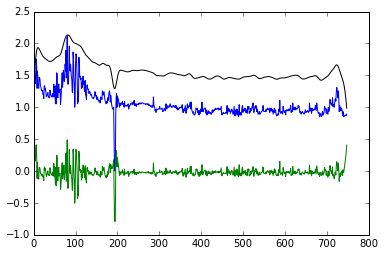

In [159]:
normConvProf = convolvedProf/np.median(convolvedProf)
normProf = dfTmp['hb'][selSleep[0]]/np.median(dfTmp['hb'][selSleep[0]])
plot(normConvProf+0.5, 'k')
plot(normProf)
print np.std(normProf-normConvProf)
plot(normProf-normConvProf)

IndexError: index 720 is out of bounds for axis 1 with size 720

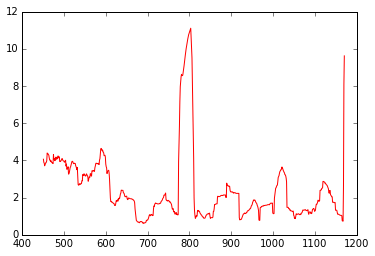

In [136]:
dfTmp = dicDF[dicDF.keys()[0]]

# Rolling mean
binSize = 30 # A hour bin

# plot(mm[:-binSize+1], 
#      dfTmp['hb'][:-binSize+1]-rollingMean(dfTmp['hb'], binSize=binSize), 
#      color='k')
# plot(mm, dfTmp['hb'])

rStd = rollingStd(dfTmp['hb'][selSleep[0]], binSize=binSize)

plot(mm[selSleep][:-binSize+1], rStd, c='r')

print mean(rStd[selSleep])

0.0125694762918


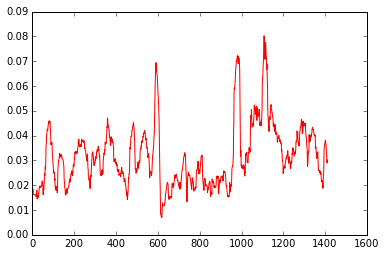

In [72]:
rGini = rollingGini(dfTmp['hb'], binSize=binSize)
plot(mm[:-binSize+1], rGini, c='r')

print std(rGini)

0.0490427912628


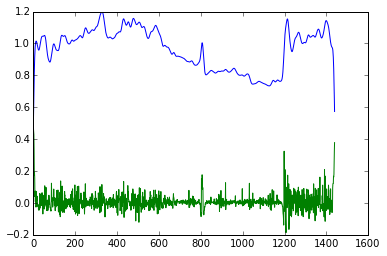

In [66]:
# Try convolving the signal with a Gaussian

from scipy import signal, misc
sigmaGaussian = 5 #In minutes
w = signal.gaussian(len(dfTmp['hb']), sigmaGaussian)

convolvedProf = np.convolve(dfTmp['hb'], w, mode='same')

normConvProf = convolvedProf/np.median(convolvedProf)
plot(normConvProf, c='b')

normProf = dfTmp['hb']/np.median(dfTmp['hb'])
# plot(normProf, c='k')

plot(mm, normProf-normConvProf)

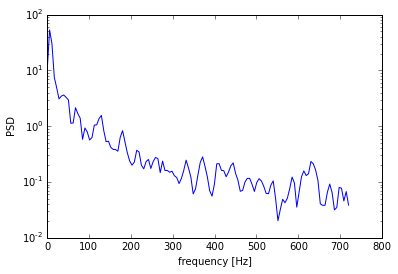

In [27]:
# Welch's method to estimate the power at different frequencies
f, Pwelch_spec = signal.welch(dfTmp['hb'], len(dfTmp['hb']), scaling='spectrum')
plt.semilogy(f, Pwelch_spec)

plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
 

In [122]:

print gini(np.random.random(1e3))

'''
# Experiments with rolling Gini
valuesGini = []
for ii in np.arange(1e3):
    aa = np.random.randn(1e2)
    raa = rollingGini(aa, binSize=binSize)
    valuesGini.append(np.std(raa))
#plot(raa)
#print np.mean(raa), np.std(raa)
'''


0.323949518794


'\n# Experiments with rolling Gini\nvaluesGini = []\nfor ii in np.arange(1e3):\n    aa = np.random.randn(1e2)\n    raa = rollingGini(aa, binSize=binSize)\n    valuesGini.append(np.std(raa))\n#plot(raa)\n#print np.mean(raa), np.std(raa)\n'

In [229]:
a=np.array([1,2,5,3])
sort(a)


array([1, 2, 3, 5])